[Table of Contents](./table_of_contents.ipynb)

# Discrete Bayes Filter

In [1]:
from __future__ import division, print_function
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


The Kalman filter belongs to a family of filters called *Bayesian filters*. Most textbook treatments of the Kalman filter present the Bayesian formula, perhaps shows how it factors into the Kalman filter equations, but mostly keeps the discussion at a very abstract level. 

That approach requires a fairly sophisticated understanding of several fields of mathematics, and it still leaves much of the work of understanding and forming an intuitive grasp of the situation in the hands of the reader.

I will use a different way to develop the topic, to which I owe the work of Dieter Fox and Sebastian Thrun a great debt. It depends on building an intuition on how Bayesian statistics work by tracking an object through a hallway - they use a robot, I use a dog. I like dogs, and they are less predictable than robots which imposes interesting difficulties for filtering. The first published example of this that I can find seems to be Fox 1999 [1], with a fuller example in Fox 2003 [2]. Sebastian Thrun also uses this formulation in his excellent Udacity course Artificial Intelligence for Robotics [3]. In fact, if you like watching videos, I highly recommend pausing reading this book in favor of first few lessons of that course, and then come back to this book for a deeper dive into the topic.

Let's now use a simple thought experiment, much like we did with the g-h filter, to see how we might reason about the use of probabilities for filtering and tracking.

## Tracking a Dog

Let's begin with a simple problem. We have a dog friendly workspace, and so people bring their dogs to work. Occasionally the dogs wander out of offices and down the halls. We want to be able to track them. So during a hackathon somebody invented a sonar sensor to attach to the dog's collar. It emits a signal, listens for the echo, and based on how quickly an echo comes back we can tell whether the dog is in front of an open doorway or not. It also senses when the dog walks, and reports in which direction the dog has moved. It connects to the network via wifi and sends an update once a second.

I want to track my dog Simon, so I attach the device to his collar and then fire up Python, ready to write code to track him through the building. At first blush this may appear impossible. If I start listening to the sensor of Simon's collar I might read **door**, **hall**, **hall**, and so on. How can I use that information to determine where Simon is?

To keep the problem small enough to plot easily we will assume that there are only 10 positions in the hallway, which we will number 0 to 9, where 1 is to the right of 0. For reasons that will be clear later, we will also assume that the hallway is circular or rectangular. If you move right from position 9, you will be at position 0.  

When I begin listening to the sensor I have no reason to believe that Simon is at any particular position in the hallway. From my perspective he is equally likely to be in any position. There are 10 positions, so the probability that he is in any given position is 1/10. 

Let's represent our belief of his position in a NumPy array. I could use a Python list, but NumPy arrays offer functionality that we will be using soon.

In [3]:
import numpy as np
belief = np.array([1./10]*10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [Bayesian statistics](https://en.wikipedia.org/wiki/Bayesian_probability) this is called a [*prior*](https://en.wikipedia.org/wiki/Prior_probability). It is the probability prior to incorporating measurements or other information. More completely, this is called the *prior probability distribution*. A [*probability distribution*](https://en.wikipedia.org/wiki/Probability_distribution) is a collection of all possible probabilities for an event. Probability distributions always sum to 1 because something had to happen; the distribution lists all possible events and the probability of each.

I'm sure you've used probabilities before - as in "the probability of rain today is 30%". The last paragraph sounds like more of that. But Bayesian statistics was a revolution in probability because it treats probability as a belief about a single event. Let's take an example. I know that if I flip a fair coin infinitely many times I will get 50% heads and 50% tails. This is called [*frequentist statistics*](https://en.wikipedia.org/wiki/Frequentist_inference) to distinguish it from Bayesian statistics. Computations are based on the frequency in which events occur.

I flip the coin one more time and let it land. Which way do I believe it landed? Frequentist probability has nothing to say about that; it will merely state that 50% of coin flips land as heads. In some ways it is meaningless to assign a probability to the current state of the coin. It is either heads or tails, we just don't know which. Bayes treats this as a belief about a single event - the strength of my belief or knowledge that this specific coin flip is heads is 50%. Some object to the term "belief"; belief can imply holding something to be true without evidence. In this book it always is a measure of the strength of our knowledge. We'll learn more about this as we go.

Bayesian statistics takes past information (the prior) into account. We observe that it rains 4 times every 100 days. From this I could state that the chance of rain tomorrow is 1/25. This is not how weather prediction is done. If I know it is raining today and the storm front is stalled, it is likely to rain tomorrow. Weather prediction is Bayesian.

In practice statisticians use a mix of frequentist and Bayesian techniques. Sometimes finding the prior is difficult or impossible, and frequentist techniques rule. In this book we can find the prior. When I talk about the probability of something I am referring to the probability that some specific thing is true given past events. When I do that I'm taking the Bayesian approach.

Now let's create a map of the hallway. We'll place the first two doors close together, and then another door further away. We will use 1 for doors, and 0 for walls:

In [4]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

I start listening to Simon's transmissions on the network, and the first data I get from the sensor is **door**. For the moment assume the sensor always returns the correct answer. From this I conclude that he is in front of a door, but which one? I have no reason to believe he is in front of the first, second, or third door. What I can do is assign a probability to each door. All doors are equally likely, and there are three of them, so I assign a probability of 1/3 to each door. 

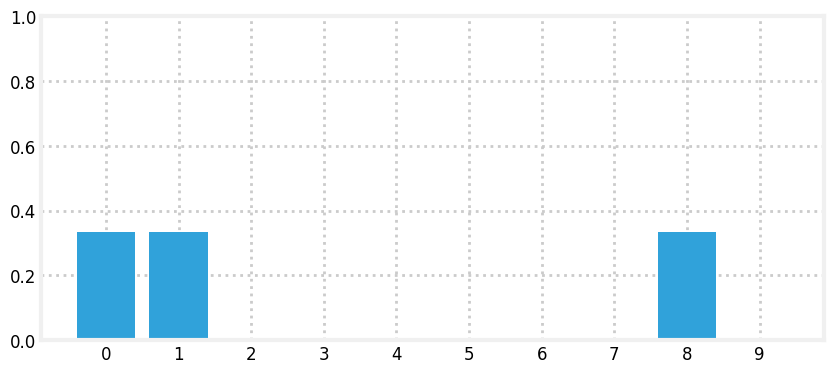

In [5]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import figsize, set_figsize
import matplotlib.pyplot as plt

belief = np.array([1./3, 1./3, 0, 0, 0, 0, 0, 0, 1/3, 0])
book_plots.bar_plot(belief)

This distribution is called a [*categorical distribution*](https://en.wikipedia.org/wiki/Categorical_distribution), which is a discrete distribution describing the probability of observing $n$ outcomes. It is a [*multimodal distribution*](https://en.wikipedia.org/wiki/Multimodal_distribution) because we have multiple beliefs about the position of our dog. Of course we are not saying that we think he is simultaneously in three different locations, merely that we have narrowed down our knowledge to one of these three locations. My (Bayesian) belief is that there is a 33.3% chance of being at door 0, 33.3% at door 1, and a 33.3% chance of being at door 8.

This is an improvement in two ways. I've rejected a number of hallway positions as impossible, and the strength of my belief in the remaining positions has increased from 10% to 33%. This will always happen. As our knowledge improves the probabilities will get closer to 100%.

A few words about the [*mode*](https://en.wikipedia.org/wiki/Mode_(statistics&#41;)
of a distribution. Given a set of numbers, such as {1, 2, 2, 2, 3, 3, 4}, the *mode* is the number that occurs most often. For this set the mode is 2. A set can contain more than one mode. The set {1, 2, 2, 2, 3, 3, 4, 4, 4} contains the modes 2 and 4, because both occur three times. We say the former set is [*unimodal*](https://en.wikipedia.org/wiki/Unimodality), and the latter is *multimodal*.

Another term used for this distribution is a [*histogram*](https://en.wikipedia.org/wiki/Histogram). Histograms graphically depict the distribution of a set of numbers. The bar chart above is a histogram.

I hand coded the `belief` array in the code above. How would we implement this in code? We represent doors with 1, and walls as 0, so we will multiply the hallway variable by the percentage, like so;

In [6]:
belief = hallway * (1./3)
print(belief)

[0.333 0.333 0.    0.    0.    0.    0.    0.    0.333 0.   ]


## Extracting Information from Sensor Readings

Let's put Python aside and think about the problem a bit. Suppose we were to read the following from Simon's sensor:

  * door
  * move right
  * door
  

Can we deduce Simon's location? Of course! Given the hallway's layout there is only one place from which you can get this sequence, and that is at the left end. Therefore we can confidently state that Simon is in front of the second doorway. If this is not clear, suppose Simon had started at the second or third door. After moving to the right, his sensor would have returned 'wall'. That doesn't match the sensor readings, so we know he didn't start there. We can continue with that logic for all the remaining starting positions. The only possibility is that he is now in front of the second door. Our belief is:

In [7]:
belief = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

I designed the hallway layout and sensor readings to give us an exact answer quickly. Real problems are not so clear cut. But this should trigger your intuition - the first sensor reading only gave us low probabilities (0.333) for Simon's location, but after a position update and another sensor reading we know more about where he is. You might suspect, correctly, that if you had a very long hallway with a large number of doors that after several sensor readings and positions updates we would either be able to know where Simon was, or have the possibilities narrowed down to a small number of possibilities. This is possible when a set of sensor readings only matches one to a few starting locations.

We could implement this solution now, but instead let's consider a real world complication to the problem.

## Noisy Sensors

Perfect sensors are rare. Perhaps the sensor would not detect a door if Simon sat in front of it while scratching himself, or misread if he is not facing down the hallway. Thus when I get **door** I cannot use 1/3 as the probability. I have to assign less than 1/3 to each door, and assign a small probability to each blank wall position. Something like

```Python
[.31, .31, .01, .01, .01, .01, .01, .01, .31, .01]
```

At first this may seem insurmountable. If the sensor is noisy it casts doubt on every piece of data. How can we conclude anything if we are always unsure?

The answer, as for the problem above, is with probabilities. We are already comfortable assigning a probabilistic belief to the location of the dog; now we have to incorporate the additional uncertainty caused by the sensor noise. 

Say we get a reading of **door**, and suppose that testing shows that the sensor is 3 times more likely to be right than wrong. We should scale the probability distribution by 3 where there is a door. If we do that the result will no longer be a probability distribution, but we will learn how to fix that in a moment.

Let's look at that in Python code. Here I use the variable `z` to denote the measurement. `z` or `y` are customary choices in the literature for the measurement. As a programmer I prefer meaningful variable names, but I want you to be able to read the literature and/or other filtering code, so I will start introducing these abbreviated names now.

belief: [0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
sum = 1.6000000000000003


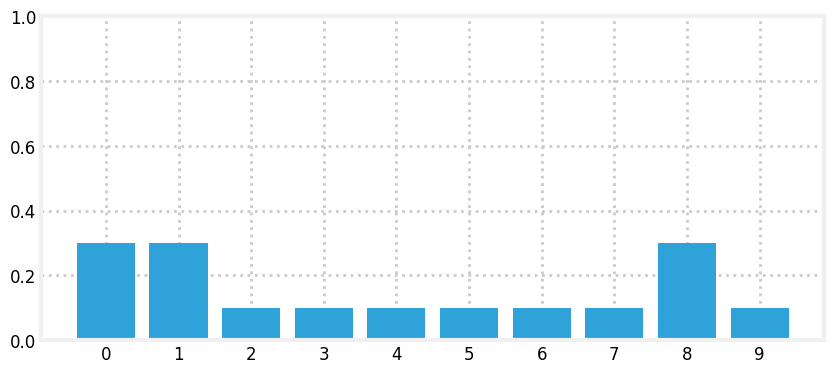

In [8]:
def update_belief(hall, belief, z, correct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale

belief = np.array([0.1] * 10)
reading = 1 # 1 is 'door'
update_belief(hallway, belief, z=reading, correct_scale=3.)
print('belief:', belief)
print('sum =', sum(belief))
plt.figure()
book_plots.bar_plot(belief)

This is not a probability distribution because it does not sum to 1.0. But the code is doing mostly the right thing - the doors are assigned a number (0.3) that is 3 times higher than the walls (0.1). All we need to do is normalize the result so that the probabilities correctly sum to 1.0. Normalization is done by dividing each element by the sum of all elements in the list. That is easy with NumPy:

In [9]:
belief / sum(belief)

array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])

FilterPy implements this with the `normalize` function:

```Python
from filterpy.discrete_bayes import normalize
normalize(belief)
```

It is a bit odd to say "3 times as likely to be right as wrong". We are working in probabilities, so let's specify the probability of the sensor being correct, and compute the scale factor from that. The equation for that is

$$scale =  \frac{prob_{correct}}{prob_{incorrect}} = \frac{prob_{correct}} {1-prob_{correct}}$$



Also, the `for` loop is cumbersome. As a general rule you will want to avoid using `for` loops in NumPy code. NumPy is implemented in C and Fortran, so if you avoid for loops the result often runs 100x faster than the equivalent loop.

How do we get rid of this `for` loop? NumPy lets you index arrays with boolean arrays. You create a boolean array with logical operators. We can find all the doors in the hallway with:

In [10]:
hallway == 1

array([ True,  True, False, False, False, False, False, False,  True,
       False])

When you use the boolean array as an index to another array it returns only the elements where the index is `True`. Thus we can replace the `for` loop with

```python
belief[hall==z] *= scale
```
and only the elements which equal `z` will be multiplied by `scale`.

Teaching you NumPy is beyond the scope of this book. I will use idiomatic NumPy constructs and explain them the first time I present them. If you are new to NumPy there are many blog posts and videos on how to use NumPy efficiently and idiomatically.

Here is our improved version:

sum = 1.0
probability of door = 0.1875
probability of wall = 0.06249999999999999


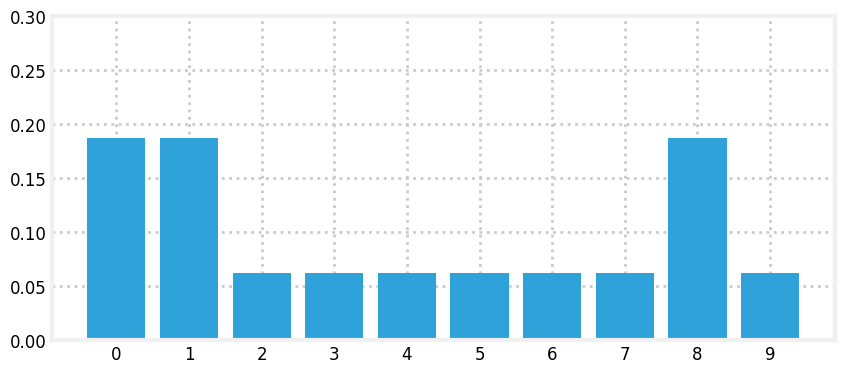

In [11]:
from filterpy.discrete_bayes import normalize

def scaled_update(hall, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob)
    belief[hall==z] *= scale
    normalize(belief)

belief = np.array([0.1] * 10)
scaled_update(hallway, belief, z=1, z_prob=.75)

print('sum =', sum(belief))
print('probability of door =', belief[0])
print('probability of wall =', belief[2])
book_plots.bar_plot(belief, ylim=(0, .3))

 We can see from the output that the sum is now 1.0, and that the probability of a door vs wall is still three times larger. The result also fits our intuition that the probability of a door must be less than 0.333, and that the probability of a wall must be greater than 0.0. Finally, it should fit our intuition that we have not yet been given any information that would allow us to distinguish between any given door or wall position, so all door positions should have the same value, and the same should be true for wall positions.
 
This result is called the [*posterior*](https://en.wikipedia.org/wiki/Posterior_probability), which is short for *posterior probability distribution*. All this means is a probability distribution *after* incorporating the measurement information (posterior means 'after' in this context). To review, the *prior* is the probability distribution before including the measurement's information. 

Another term is the [*likelihood*](https://en.wikipedia.org/wiki/Likelihood_function). When we computed `belief[hall==z] *= scale` we were computing how *likely* each position was given the measurement. The likelihood is not a probability distribution because it does not sum to one.

The combination of these gives the equation

$$\mathtt{posterior} = \frac{\mathtt{likelihood} \times \mathtt{prior}}{\mathtt{normalization}}$$ 

When we talk about the filter's output we typically call the state after performing the prediction the *prior* or *prediction*, and we call the state after the update either the *posterior* or the *estimated state*. 

It is very important to learn and internalize these terms as most of the literature uses them extensively.

Does `scaled_update()` perform this computation? It does. Let me recast it into this form:

In [12]:
def scaled_update(hall, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob)
    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return normalize(likelihood * belief)

This function is not fully general. It contains knowledge about the hallway, and how we match measurements to it. We always strive to write general functions. Here we will remove the computation of the likelihood from the function, and require the caller to compute the likelihood themselves.

Here is a full implementation of the algorithm:

```python
def update(likelihood, prior):
    return normalize(likelihood * prior)
```

Computation of the likelihood varies per problem. For example, the sensor might not return  just 1 or 0, but a `float` between 0 and 1 indicating the probability of being in front of a door. It might use computer vision and report a blob shape that you then probabilistically match to a door. It might use sonar and return a distance reading. In each case the computation of the likelihood will be different. We will see many examples of this throughout the book, and learn how to perform these calculations.

FilterPy implements `update`. Here is the previous example in a fully general form:

In [13]:
from filterpy.discrete_bayes import update

def lh_hallway(hall, z, z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""
    
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return likelihood

belief = np.array([0.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
update(likelihood, belief)  

array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])

## Incorporating Movement

Recall how quickly we were able to find an exact solution when we incorporated a series of measurements and movement updates. However, that occurred in a fictional world of perfect sensors. Might we be able to find an exact solution with noisy sensors?

Unfortunately, the answer is no. Even if the sensor readings perfectly match an extremely complicated hallway map, we cannot be 100% certain that the dog is in a specific position - there is, after all, a tiny possibility that every sensor reading was wrong! Naturally, in a more typical situation most sensor readings will be correct, and we might be close to 100% sure of our answer, but never 100% sure. This may seem complicated, but let's go ahead and program the math.

First let's deal with the simple case - assume the movement sensor is perfect, and it reports that the dog has moved one space to the right. How would we alter our `belief` array?

I hope that after a moment's thought it is clear that we should shift all the values one space to the right. If we previously thought there was a 50% chance of Simon being at position 3, then after he moved one position to the right we should believe that there is a 50% chance he is at position 4. The hallway is circular, so we will use modulo arithmetic to perform the shift.

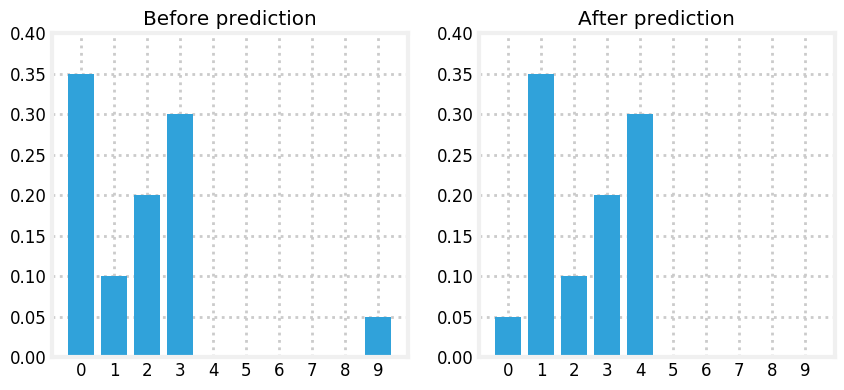

In [14]:
def perfect_predict(belief, move):
    """ move the position by `move` spaces, where positive is 
    to the right, and negative is to the left
    """
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i-move) % n]
    return result
        
belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
plt.subplot(121)
book_plots.bar_plot(belief, title='Before prediction', ylim=(0, .4))

belief = perfect_predict(belief, 1)
plt.subplot(122)
book_plots.bar_plot(belief, title='After prediction', ylim=(0, .4))

We can see that we correctly shifted all values one position to the right, wrapping from the end of the array back to the beginning. 

The next cell animates this so you can see it in action. Use the slider to move forwards and backwards in time. This simulates Simon walking around and around the hallway. It does not yet incorporate new measurements so the probability distribution does not change shape, only position.

In [16]:
from ipywidgets import interact, IntSlider

belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
beliefs = []

for _ in range(20):
    # Simon takes one step to the right
    belief = perfect_predict(belief, 1)
    beliefs.append(belief)

def simulate(time_step):
    book_plots.bar_plot(beliefs[time_step], ylim=(0, .4))
    
interact(simulate, time_step=IntSlider(value=0, max=len(beliefs)-1));

interactive(children=(IntSlider(value=0, description='time_step', max=19), Output()), _dom_classes=('widget-in…

## Terminology

Let's pause a moment to review terminology. I introduced this terminology in the last chapter, but let's take a second to help solidify your knowledge. 

The *system* is what we are trying to model or filter. Here the system is our dog. The *state* is its current configuration or value. In this chapter the state is our dog's position. We rarely know the actual state, so we say our filters produce the *estimated state* of the system. In practice this often gets called the state, so be careful to understand the context.
 
One cycle of prediction and updating with a measurement is called the state or system *evolution*, which is short for *time evolution* [7]. Another term is *system propagation*. It refers to how the state of the system changes over time. For filters, time is usually a discrete step, such as 1 second. For our dog tracker the system state is the position of the dog, and the state evolution is the position after a discrete amount of time has passed.

We model the system behavior with the *process model*. Here, our process model is that the dog moves one or more positions at each time step. This is not a particularly accurate model of how dogs behave. The error in the model is called the *system error* or *process error*. 

The prediction is our new *prior*. Time has moved forward and we made a prediction without benefit of knowing the measurements. 

Let's work an example. The current position of the dog is 17 m. Our epoch is 2 seconds long, and the dog is traveling at 15 m/s. Where do we predict he will be in two seconds? 

Clearly,

$$ \begin{aligned}
\bar x &= 17 + (15*2) \\
&= 47
\end{aligned}$$

I use bars over variables to indicate that they are priors (predictions). We can write the equation for the process model like this:

$$ \bar x_{k+1} = f_x(\bullet) + x_k$$

$x_k$ is the current position or state. If the dog is at 17 m then $x_k = 17$.

$f_x(\bullet)$ is the state propagation function for x. It describes how much the $x_k$ changes over one time step. For our example it performs the computation $15 \cdot 2$ so we would define it as 

$$f_x(v_x, t) = v_k t$$.

## Adding Uncertainty to the Prediction

`perfect_predict()` assumes perfect measurements, but all sensors have noise. What if the sensor reported that our dog moved one space, but he actually moved two spaces, or zero? This may sound like an insurmountable problem, but let's model it and see what happens.

Assume that the sensor's movement measurement is 80% likely to be correct, 10% likely to overshoot one position to the right, and 10% likely to undershoot to the left. That is, if the movement measurement is 4 (meaning 4 spaces to the right), the dog is 80% likely to have moved 4 spaces to the right, 10% to have moved 3 spaces, and 10% to have moved 5 spaces.

Each result in the array now needs to incorporate probabilities for 3 different situations. For example, consider the reported movement of 2. If we are 100% certain the dog started from position 3, then there is an 80% chance he is at 5, and a 10% chance for either 4 or 6. Let's try coding that:

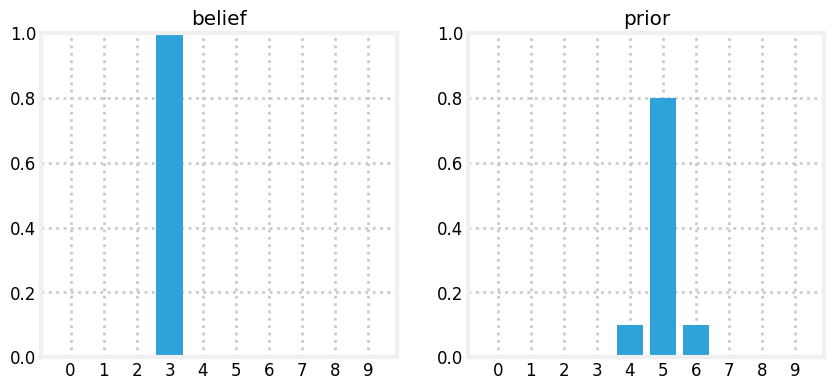

In [17]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)      
    return prior

belief = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)

It appears to work correctly. Now what happens when our belief is not 100% certain?

array([0.  , 0.  , 0.  , 0.04, 0.38, 0.52, 0.06, 0.  , 0.  , 0.  ])

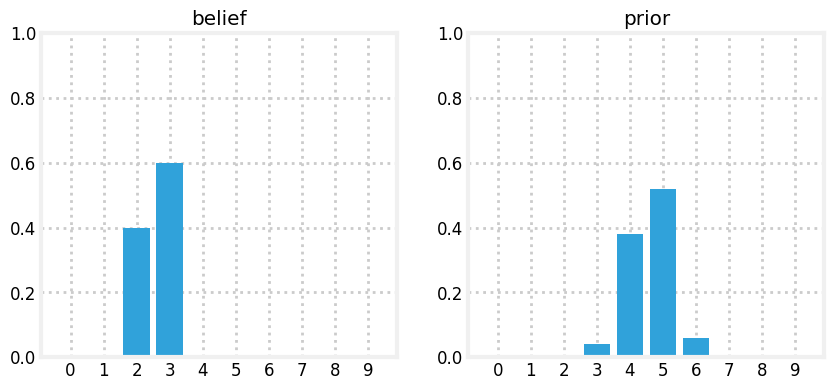

In [18]:
belief = [0, 0, .4, .6, 0, 0, 0, 0, 0, 0]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)
prior

Here the results are more complicated, but you should still be able to work it out in your head. The 0.04 is due to the possibility that the 0.4 belief undershot by 1. The 0.38 is due to the following: the 80% chance that we moved 2 positions (0.4 $\times$ 0.8) and the 10% chance that we undershot (0.6 $\times$ 0.1). Overshooting plays no role here because if we overshot both 0.4 and 0.6 would be past this position. **I strongly suggest working some examples until all of this is very clear, as so much of what follows depends on understanding this step.**

If you look at the probabilities after performing the update you might be dismayed. In the example above we started with probabilities of 0.4 and 0.6 in two positions; after performing the update the probabilities are not only lowered, but they are strewn out across the map.

This is not a coincidence, or the result of a carefully chosen example - it is always true of the prediction. If the sensor is noisy we lose some information on every prediction. Suppose we were to perform the prediction an infinite number of times - what would the result be? If we lose information on every step, we must eventually end up with no information at all, and our probabilities will be equally distributed across the `belief` array. Let's try this with 100 iterations. The plot is animated; use the slider to change the step number.

In [21]:
belief = np.array([1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
beliefs = []
    
for i in range(100):
    belief = predict_move(belief, 1, .1, .8, .1)
    beliefs.append(belief)

print('Final Belief:', belief)

# make interactive plot
def show_prior(step):
    book_plots.bar_plot(beliefs[step-1])
    plt.title('Step {}'.format(step))

interact(show_prior, step=IntSlider(value=1, max=len(beliefs)));

Final Belief: [0.104 0.103 0.101 0.099 0.097 0.096 0.097 0.099 0.101 0.103]


interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

In [22]:
print('Final Belief:', belief)

Final Belief: [0.104 0.103 0.101 0.099 0.097 0.096 0.097 0.099 0.101 0.103]


After 100 iterations we have lost almost all information, even though we were 100% sure that we started in position 0. Feel free to play with the numbers to see the effect of differing number of updates. For example, after 100 updates a small amount of information is left, after 50 a lot is left, but by 200 iterations essentially all information is lost.

And, if you are viewing this online here is an animation of that output.
<img src="animations/02_no_info.gif">

I will not generate these standalone animations through the rest of the book. Please see the preface for instructions to run this book on the web, for free, or install IPython on your computer. This will allow you to run all of the cells and see the animations. It's very important that you practice with this code, not just read passively.

## Generalizing with Convolution

We made the assumption that the movement error is at most one position. But it is possible for the error to be two, three, or more positions. As programmers we always want to generalize our code so that it works for all cases. 

This is easily solved with [*convolution*](https://en.wikipedia.org/wiki/Convolution). Convolution modifies one function with another function. In our case we are modifying a probability distribution with the error function of the sensor. The implementation of `predict_move()` is a convolution, though we did not call it that. Formally, convolution is defined as

$$ (f \ast g) (t) = \int_0^t \!f(\tau) \, g(t-\tau) \, \mathrm{d}\tau$$

where $f\ast g$ is the notation for convolving f by g. It does not mean multiply.

Integrals are for continuous functions, but we are using discrete functions. We replace the integral with a summation, and the parenthesis with array brackets.

$$ (f \ast g) [t] = \sum\limits_{\tau=0}^t \!f[\tau] \, g[t-\tau]$$

Comparison shows that `predict_move()` is computing this equation - it computes the sum of a series of multiplications.

[Khan Academy](https://www.khanacademy.org/math/differential-equations/laplace-transform/convolution-integral/v/introduction-to-the-convolution) [4] has a good introduction to convolution, and Wikipedia has some excellent animations of convolutions [5]. But the general idea is already clear. You slide an array called the *kernel* across another array, multiplying the neighbors of the current cell with the values of the second array. In our example above we used 0.8 for the probability of moving to the correct location, 0.1 for undershooting, and 0.1 for overshooting. We make a kernel of this with the array `[0.1, 0.8, 0.1]`. All we need to do is write a loop that goes over each element of our array, multiplying by the kernel, and summing the results. To emphasize that the belief is a probability distribution I have named it `pdf`.

In [23]:
def predict_move_convolution(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN - 1) / 2)

    prior = np.zeros(N)
    for i in range(N):
        for k in range (kN):
            index = (i + (width-k) - offset) % N
            prior[i] += pdf[index] * kernel[k]
    return prior

This illustrates the algorithm, but it runs very slow. SciPy provides a convolution routine `convolve()` in the `ndimage.filters` module. We  need to shift the pdf by `offset` before convolution; `np.roll()` does that. The move and predict algorithm can be implemented with one line:

```python
convolve(np.roll(pdf, offset), kernel, mode='wrap')
```

FilterPy implements this with `discrete_bayes`' `predict()` function.

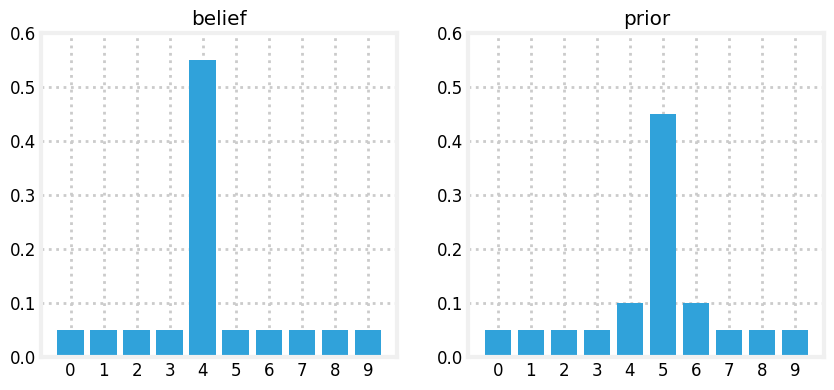

In [24]:
from filterpy.discrete_bayes import predict

belief = [.05, .05, .05, .05, .55, .05, .05, .05, .05, .05]
prior = predict(belief, offset=1, kernel=[.1, .8, .1])
book_plots.plot_belief_vs_prior(belief, prior, ylim=(0,0.6))

All of the elements are unchanged except the middle ones. The values in position 4 and 6 should be 
$$(0.1 \times 0.05)+ (0.8 \times 0.05) + (0.1 \times 0.55) = 0.1$$

Position 5 should be $$(0.1 \times 0.05) + (0.8 \times 0.55)+ (0.1 \times 0.05) = 0.45$$

Let's ensure that it shifts the positions correctly for movements greater than one and for asymmetric kernels.

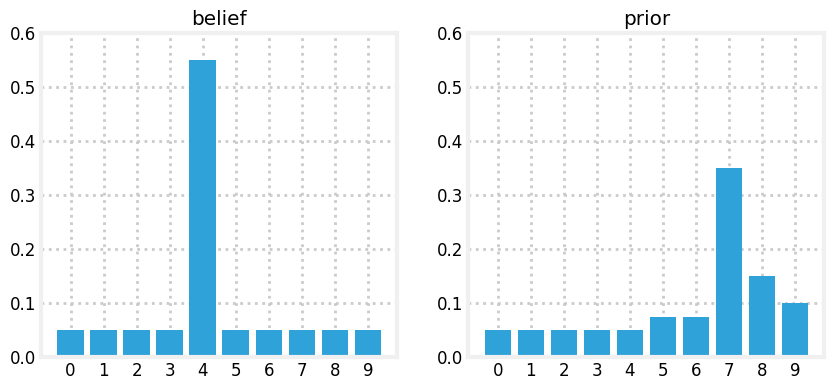

In [25]:
prior = predict(belief, offset=3, kernel=[.05, .05, .6, .2, .1])
book_plots.plot_belief_vs_prior(belief, prior, ylim=(0,0.6))

The position was correctly shifted by 3 positions and we give more weight to the likelihood of an overshoot vs an undershoot, so this looks correct.

Make sure you understand what we are doing. We are making a prediction of where the dog is moving, and convolving the probabilities to get the prior.

If we weren't using probabilities we would use this equation that I gave earlier:

$$ \bar x_{k+1} = x_k + f_{\mathbf x}(\bullet)$$

The prior, our prediction of where the dog will be, is the amount the dog moved plus his current position. The dog was at 10, he moved 5 meters, so he is now at 15 m. It couldn't be simpler. But we are using probabilities to model this, so our equation is:

$$ \bar{ \mathbf x}_{k+1} = \mathbf x_k \ast f_{\mathbf x}(\bullet)$$

We are *convolving* the current probabilistic position estimate with a probabilistic estimate of how much we think the dog moved. It's the same concept, but the math is slightly different. $\mathbf x$ is bold to denote that it is an array of numbers. 

## Integrating Measurements and Movement Updates

The problem of losing information during a prediction may make it seem as if our system would quickly devolve into having no knowledge. However, each prediction is followed by an update where we incorporate the measurement into the estimate. The update improves our knowledge. The output of the update step is fed into the next prediction. The prediction degrades our certainty. That is passed into another update, where certainty is again increased.

Let's think about this intuitively. Consider a simple case - you are tracking a dog while he sits still. During each prediction you predict he doesn't move. Your filter quickly *converges* on an accurate estimate of his position. Then the microwave in the kitchen turns on, and he goes streaking off. You don't know this, so at the next prediction you predict he is in the same spot. But the measurements tell a different story. As you incorporate the measurements your belief will be smeared along the hallway, leading towards the kitchen. On every epoch (cycle) your belief that he is sitting still will get smaller, and your belief that he is inbound towards the kitchen at a startling rate of speed increases.

That is what intuition tells us. What does the math tell us?

We have already programmed the update and predict steps. All we need to do is feed the result of one into the other, and we will have implemented a dog tracker!!! Let's see how it performs. We will input measurements as if the dog started at position 0 and moved right one position each epoch. As in a real world application, we will start with no knowledge of his position by assigning equal probability to all positions. 

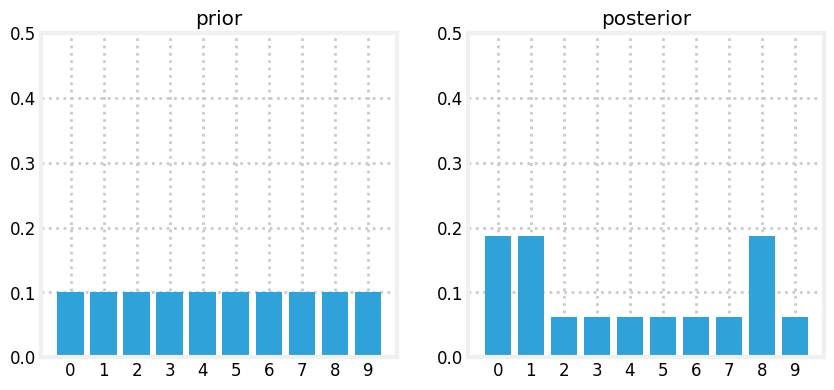

In [26]:
from filterpy.discrete_bayes import update

hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
prior = np.array([.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

After the first update we have assigned a high probability to each door position, and a low probability to each wall position. 

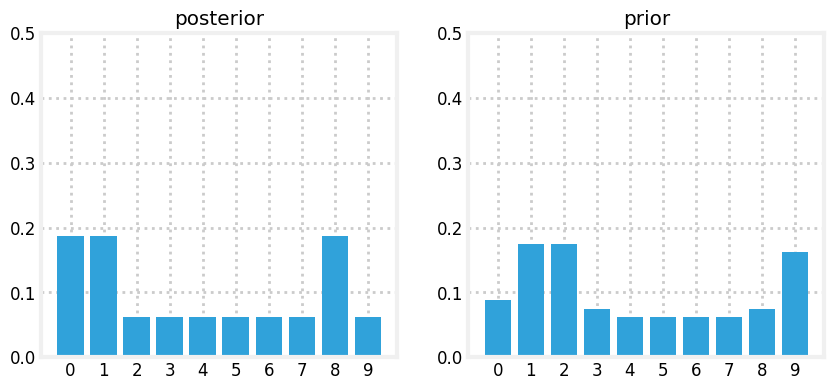

In [27]:
kernel = (.1, .8, .1)
prior = predict(posterior, 1, kernel)
book_plots.plot_prior_vs_posterior(prior, posterior, True, ylim=(0,.5))

The predict step shifted these probabilities to the right, smearing them about a bit. Now let's look at what happens at the next sense.

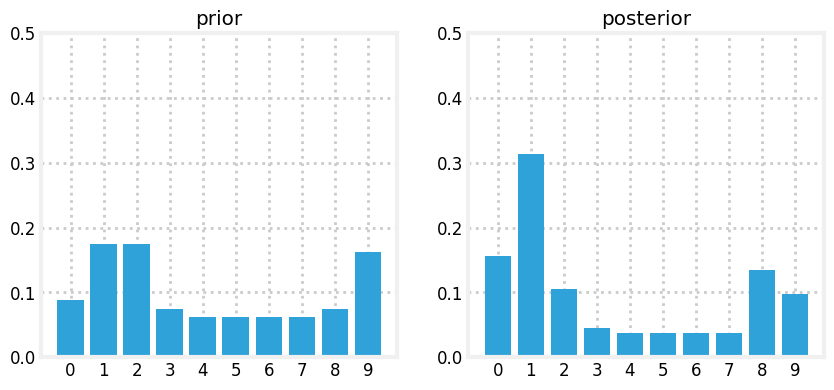

In [28]:
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

Notice the tall bar at position 1. This corresponds with the (correct) case of starting at position 0, sensing a door, shifting 1 to the right, and sensing another door. No other positions make this set of observations as likely. Now we will add an update and then sense the wall.

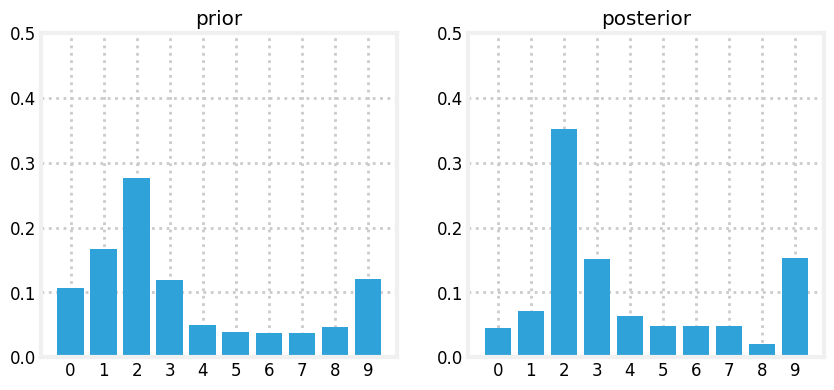

In [29]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

This is exciting! We have a very prominent bar at position 2 with a value of around 35%. It is over twice the value of any other bar in the plot, and is about 4% larger than our last plot, where the tallest bar was around 31%. Let's see one more cycle.

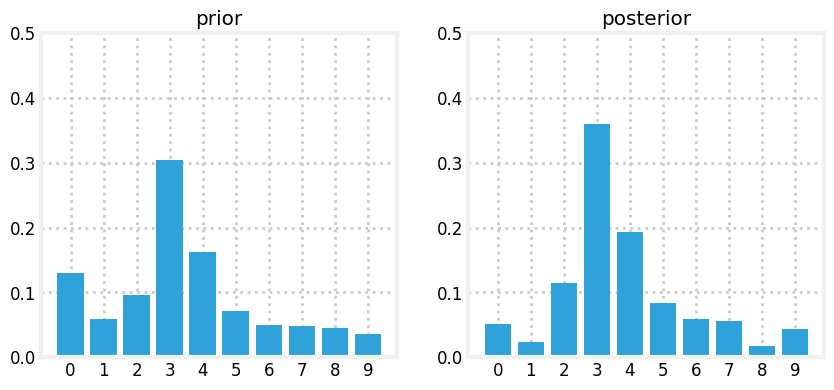

In [30]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

I ignored an important issue. Earlier I assumed that we had a motion sensor for the predict step; then, when talking about the dog and the microwave I assumed that you had no knowledge that he suddenly began running. I mentioned that your belief that the dog is running would increase over time, but I did not provide any code for this. In short, how do we detect and/or estimate changes in the process model if we aren't directly measuring it?

For now I want to ignore this problem. In later chapters we will learn the mathematics behind this estimation; for now it is a large enough task just to learn this algorithm. It is profoundly important to solve this problem, but we haven't yet built enough of the mathematical apparatus that is required, and so for the remainder of the chapter we will ignore the problem by assuming we have a sensor that senses movement.

## The Discrete Bayes Algorithm

This chart illustrates the algorithm:

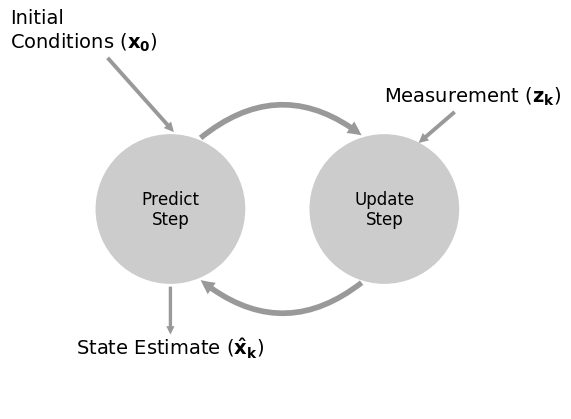

In [31]:
book_plots.predict_update_chart()

This filter is a form of the g-h filter. Here we are using the percentages for the errors to implicitly compute the $g$ and $h$ parameters. We could express the discrete Bayes algorithm as a g-h filter, but that would obscure the logic of this filter.

The filter equations are:

$$\begin{aligned} \bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{Predict Step} \\
\mathbf x &= \|\mathcal L \cdot \bar{\mathbf x}\|\, \, &\text{Update Step}\end{aligned}$$

$\mathcal L$ is the usual way to write the likelihood function, so I use that. The $\|\|$ notation denotes taking the norm. We need to normalize the product of the likelihood with the prior to ensure $x$ is a probability distribution that sums to one.

We can express this in pseudocode.

**Initialization**

    1. Initialize our belief in the state
    
**Predict**

    1. Based on the system behavior, predict state for the next time step
    2. Adjust belief to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute how likely it is the measurement matches each state
    3. Update state belief with this likelihood

When we cover the Kalman filter we will use this exact same algorithm; only the details of the computation will differ.

Algorithms in this form are sometimes called *predictor correctors*. We make a prediction, then correct them.

Let's animate this. First Let's write functions to perform the filtering and to plot the results at any step. I've plotted the position of the doorways in black. Prior are drawn in orange, and the posterior in blue. I draw a thick vertical line to indicate where Simon really is. This is not an output of the filter - we know where Simon is only because we are simulating his movement.

In [32]:
def discrete_bayes_sim(prior, kernel, measurements, z_prob, hallway):
    posterior = np.array([.1]*10)
    priors, posteriors = [], []
    for i, z in enumerate(measurements):
        prior = predict(posterior, 1, kernel)
        priors.append(prior)

        likelihood = lh_hallway(hallway, z, z_prob)
        posterior = update(likelihood, prior)
        posteriors.append(posterior)
    return priors, posteriors


def plot_posterior(posteriors, i):
    plt.title('Posterior')
    book_plots.bar_plot(hallway, c='k')
    book_plots.bar_plot(posteriors[i], ylim=(0, 1.0))
    plt.axvline(i % len(hallway), lw=5)    
    
def plot_prior(priors, i):
    plt.title('Prior')
    book_plots.bar_plot(hallway, c='k')
    book_plots.bar_plot(priors[i], ylim=(0, 1.0), c='#ff8015')
    plt.axvline(i % len(hallway), lw=5)    

def animate_discrete_bayes(step):
    step -= 1
    i = step // 2    
    if step % 2 == 0:
        plot_prior(priors, i)
    else:
        plot_posterior(posteriors, i)

Let's run the filter and animate it.

In [34]:
# change these numbers to alter the simulation
kernel = (.1, .8, .1)
z_prob = 1.0
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

# measurements with no noise
zs = [hallway[i % len(hallway)] for i in range(50)]

priors, posteriors = discrete_bayes_sim(prior, kernel, zs, z_prob, hallway)
interact(animate_discrete_bayes, step=IntSlider(value=1, max=len(zs)*2));

interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

Now we can see the results. You can see how the prior shifts the position and reduces certainty, and the posterior stays in the same position and increases certainty as it incorporates the information from the measurement. I've made the measurement perfect with the line `z_prob = 1.0`; we will explore the effect of imperfect measurements in the next section. Finally, 

Another thing to note is how accurate our estimate becomes when we are in front of a door, and how it degrades when in the middle of the hallway. This should make intuitive sense. There are only a few doorways, so when the sensor tells us we are in front of a door this boosts our certainty in our position. A long stretch of no doors reduces our certainty.

## The Effect of Bad Sensor Data

You may be suspicious of the results above because I always passed correct sensor data into the functions. However, we are claiming that this code implements a *filter* - it should filter out bad sensor measurements. Does it do that?

To make this easy to program and visualize I will change the layout of the hallway to mostly alternating doors and hallways, and run the algorithm on 6 correct measurements:

In [35]:
hallway = np.array([1, 0, 1, 0, 0]*2)
kernel = (.1, .8, .1)
prior = np.array([.1] * 10)
zs = [1, 0, 1, 0, 0, 1]
z_prob = 0.75
priors, posteriors = discrete_bayes_sim(prior, kernel, zs, z_prob, hallway)
interact(animate_discrete_bayes, step=IntSlider(value=12, max=len(zs)*2));

interactive(children=(IntSlider(value=12, description='step', max=12), Output()), _dom_classes=('widget-intera…

We have identified the likely cases of having started at position 0 or 5, because we saw this sequence of doors and walls: 1,0,1,0,0. Now I inject a bad measurement. The next measurement should be 0, but instead we get a 1:

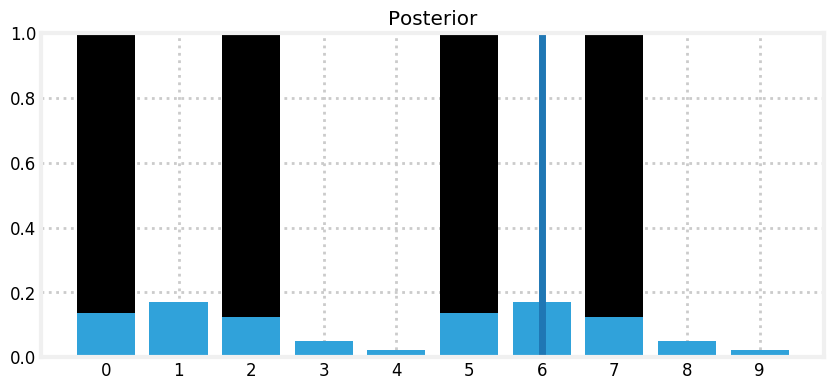

In [36]:
measurements = [1, 0, 1, 0, 0, 1, 1]
priors, posteriors = discrete_bayes_sim(prior, kernel, measurements, z_prob, hallway);
plot_posterior(posteriors, 6)

That one bad measurement has significantly eroded our knowledge. Now let's continue with a series of correct measurements.

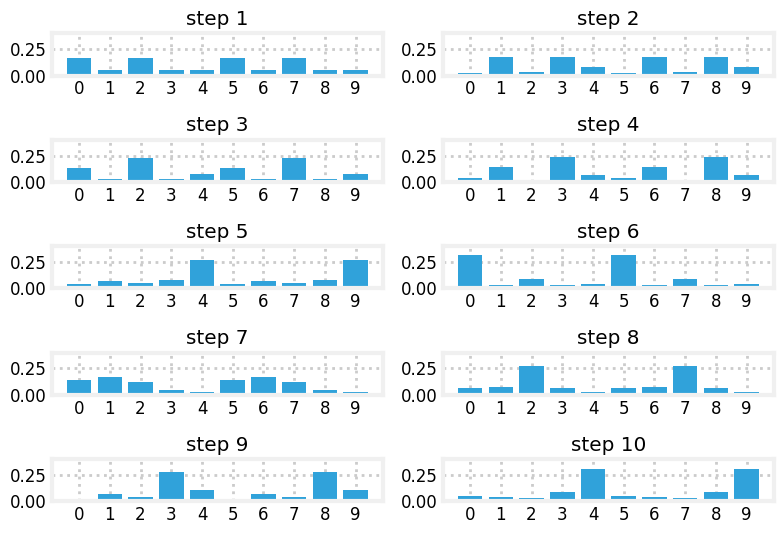

In [37]:
with figsize(y=5.5):
    measurements = [1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
    for i, m in enumerate(measurements):
        likelihood = lh_hallway(hallway, z=m, z_prob=.75)
        posterior = update(likelihood, prior)
        prior = predict(posterior, 1, kernel)
        plt.subplot(5, 2, i+1)
        book_plots.bar_plot(posterior, ylim=(0, .4), title='step {}'.format(i+1))
    plt.tight_layout()

We quickly filtered out the bad sensor reading and converged on the most likely positions for our dog.

## Drawbacks and Limitations

Do not be mislead by the simplicity of the examples I chose. This is a robust and complete filter, and you may use the code in real world solutions. If you need a multimodal, discrete filter, this filter works.

With that said, this filter it is not used often because it has several limitations. Getting around those limitations is the motivation behind the chapters in the rest of this book.

The first problem is scaling. Our dog tracking problem used only one variable, $pos$, to denote the dog's position. Most interesting problems will want to track several things in a large space. Realistically, at a minimum we would want to track our dog's $(x,y)$ coordinate, and probably his velocity $(\dot{x},\dot{y})$ as well. We have not covered the multidimensional case, but instead of an array we use a multidimensional grid to store the probabilities at each discrete location. Each `update()` and `predict()` step requires updating all values in the grid, so a simple four variable problem would require $O(n^4)$ running time *per time step*. Realistic filters can have 10 or more variables to track, leading to exorbitant computation requirements.

The second problem is that the filter is discrete, but we live in a continuous world. The histogram requires that you model the output of your filter as a set of discrete points. A 100 meter hallway requires 10,000 positions to model the hallway to 1cm accuracy. So each update and predict operation would entail performing calculations for 10,000 different probabilities. It gets exponentially worse as we add dimensions. A 100x100 m$^2$ courtyard requires 100,000,000 bins to get 1cm accuracy.

A third problem is that the filter is multimodal. In the last example we ended up with strong beliefs that the dog was in position 4 or 9. This is not always a problem. Particle filters, which we will study later, are multimodal and are often used because of this property. But imagine if the GPS in your car reported to you that it is 40% sure that you are on D street, and 30% sure you are on Willow Avenue. 

A forth problem is that it requires a measurement of the change in state. We need a motion sensor to detect how much the dog moves. There are ways to work around this problem, but it would complicate the exposition of this chapter, so, given the aforementioned problems, I will not discuss it further.

With that said, if I had a small problem that this technique could handle I would choose to use it; it is trivial to implement, debug, and understand, all virtues.

## Tracking and Control

We have been passively tracking an autonomously moving object. But consider this very similar problem. I am automating a warehouse and want to use robots to collect all of the items for a customer's order. Perhaps the easiest way to do this is to have the robots travel on a train track. I want to be able to send the robot a destination and have it go there. But train tracks and robot motors are imperfect. Wheel slippage and imperfect motors means that the robot is unlikely to travel to exactly the position you command. There is more than one robot, and we need to know where they all are so we do not cause them to crash.

So we add sensors. Perhaps we mount magnets on the track every few feet, and use a Hall sensor to count how many magnets are passed. If we count 10 magnets then the robot should be at the 10th magnet. Of course it is possible to either miss a magnet or to count it twice, so we have to accommodate some degree of error. We can use the code from the previous section to track our robot since magnet counting is very similar to doorway sensing.

But we are not done. We've learned to never throw information away. If you have information you should use it to improve your estimate. What information are we leaving out? We know what control inputs we are feeding to the wheels of the robot at each moment in time. For example, let's say that once a second we send a movement command to the robot - move left 1 unit, move right 1 unit, or stand still.  If I send the command 'move left 1 unit' I expect that in one second from now the robot will be 1 unit to the left of where it is now. This is a simplification because I am not taking acceleration into account, but I am not trying to teach control theory. Wheels and motors are imperfect. The robot might end up 0.9 units away, or maybe 1.2 units. 

Now the entire solution is clear. We assumed that the dog kept moving in whatever direction he was previously moving. That is a dubious assumption for my dog! Robots are far more predictable. Instead of making a dubious prediction based on assumption of behavior we will feed in the command that we sent to the robot! In other words, when we call `predict()` we will pass in the commanded movement that we gave the robot along with a kernel that describes the likelihood  of that movement.

### Simulating the Train Behavior

We need to simulate an imperfect train. When we command it to move it will sometimes make a small mistake, and its sensor will sometimes return the incorrect value.

In [38]:
class Train(object):

    def __init__(self, track_len, kernel=[1.], sensor_accuracy=.9):
        self.track_len = track_len
        self.pos = 0
        self.kernel = kernel
        self.sensor_accuracy = sensor_accuracy

    def move(self, distance=1):
        """ move in the specified direction
        with some small chance of error"""

        self.pos += distance
        # insert random movement error according to kernel
        r = random.random()
        s = 0
        offset = -(len(self.kernel) - 1) / 2
        for k in self.kernel:
            s += k
            if r <= s:
                break
            offset += 1
        self.pos = int((self.pos + offset) % self.track_len)
        return self.pos

    def sense(self):
        pos = self.pos
         # insert random sensor error
        if random.random() > self.sensor_accuracy:
            if random.random() > 0.5:
                pos += 1
            else:
                pos -= 1
        return pos

With that we are ready to write the filter. We will put it in a function so that we can run it with different assumptions. I will assume that the robot always starts at the beginning of the track. The track is implemented as being 10 units long, but think of it as a track of length, say 10,000, with the magnet pattern repeated every 10 units. A length of 10 makes it easier to plot and inspect.

In [39]:
def train_filter(iterations, kernel, sensor_accuracy, 
             move_distance, do_print=True):
    track = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    prior = np.array([.9] + [0.01]*9)
    posterior = prior[:]
    normalize(prior)
    
    robot = Train(len(track), kernel, sensor_accuracy)
    for i in range(iterations):
        # move the robot and
        robot.move(distance=move_distance)

        # peform prediction
        prior = predict(posterior, move_distance, kernel)       

        #  and update the filter
        m = robot.sense()
        likelihood = lh_hallway(track, m, sensor_accuracy)
        posterior = update(likelihood, prior)
        index = np.argmax(posterior)

        if do_print:
            print('''time {}: pos {}, sensed {}, '''
                  '''at position {}'''.format(
                    i, robot.pos, m, track[robot.pos]))

            print('''        estimated position is {}'''
                  ''' with confidence {:.4f}%:'''.format(
                  index, posterior[index]*100))            

    book_plots.bar_plot(posterior)
    if do_print:
        print()
        print('final position is', robot.pos)
        index = np.argmax(posterior)
        print('''Estimated position is {} with '''
              '''confidence {:.4f}%:'''.format(
                index, posterior[index]*100))

Read the code and make sure you understand it. Now let's do a run with no sensor or movement error. If the code is correct it should be able to locate the robot with no error. The output is a bit tedious to read, but if you are at all unsure of how the update/predict cycle works make sure you read through it carefully to solidify your understanding.

time 0: pos 4, sensed 4, at position 4
        estimated position is 4 with confidence 99.9900%:
time 1: pos 8, sensed 8, at position 8
        estimated position is 8 with confidence 100.0000%:
time 2: pos 2, sensed 2, at position 2
        estimated position is 2 with confidence 100.0000%:
time 3: pos 6, sensed 6, at position 6
        estimated position is 6 with confidence 100.0000%:

final position is 6
Estimated position is 6 with confidence 100.0000%:


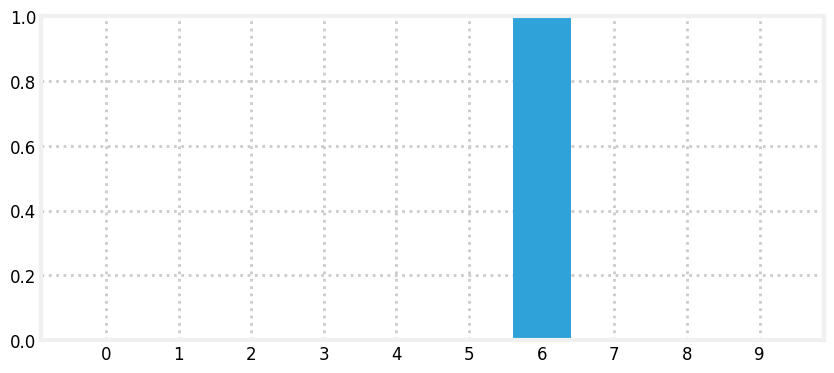

In [40]:
import random

random.seed(3)
np.set_printoptions(precision=2, suppress=True, linewidth=60)
train_filter(4, kernel=[1.], sensor_accuracy=.999,
             move_distance=4, do_print=True)

We can see that the code was able to perfectly track the robot so we should feel reasonably confident that the code is working. Now let's see how it fairs with some errors. 

time 0: pos 4, sensed 4, at position 4
        estimated position is 4 with confidence 96.0390%:
time 1: pos 8, sensed 9, at position 8
        estimated position is 9 with confidence 52.1180%:
time 2: pos 3, sensed 3, at position 3
        estimated position is 3 with confidence 88.3993%:
time 3: pos 7, sensed 8, at position 7
        estimated position is 8 with confidence 49.3174%:

final position is 7
Estimated position is 8 with confidence 49.3174%:


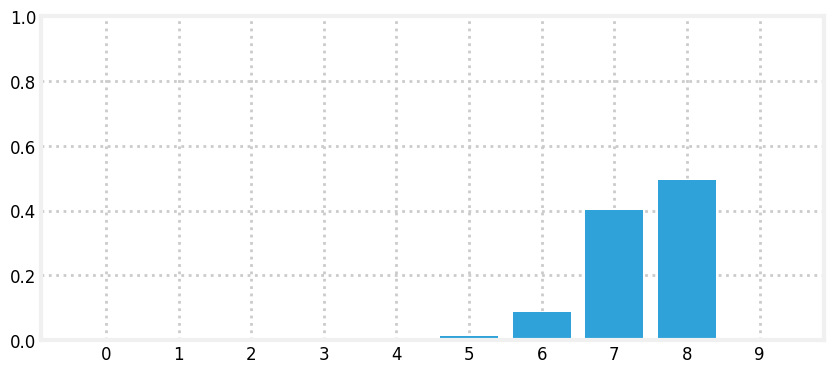

In [41]:
random.seed(5)
train_filter(4, kernel=[.1, .8, .1], sensor_accuracy=.9,
         move_distance=4, do_print=True)

There was a sensing error at time 1, but we are still quite confident in our position. 

Now let's run a very long simulation and see how the filter responds to errors.

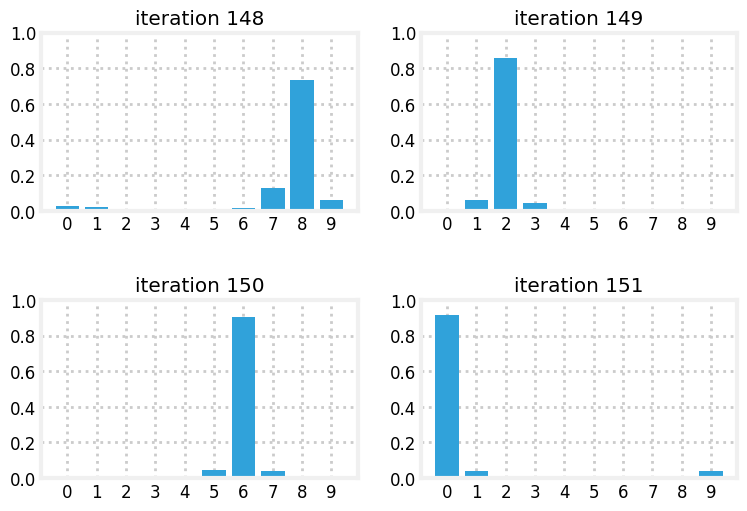

In [42]:
with figsize(y=5.5):
    for i in range (4):
        random.seed(3)
        plt.subplot(221+i)
        train_filter(148+i, kernel=[.1, .8, .1], 
                     sensor_accuracy=.8,
                     move_distance=4, do_print=False)
        plt.title ('iteration {}'.format(148+i))

We can see that there was a problem on iteration 149 as the confidence degrades. But within a few iterations the filter is able to correct itself and regain confidence in the estimated position.

## Bayes Theorem and the Total Probability Theorem

We developed the math in this chapter merely by reasoning about the information we have at each moment. In the process we discovered [*Bayes' Theorem*](https://en.wikipedia.org/wiki/Bayes%27_theorem) and the [*Total Probability Theorem*](https://en.wikipedia.org/wiki/Law_of_total_probability).

Bayes theorem tells us how to compute the probability of an event given previous information. 

We implemented the `update()` function with this probability calculation:

$$ \mathtt{posterior} = \frac{\mathtt{likelihood}\times \mathtt{prior}}{\mathtt{normalization\, factor}}$$ 

We haven't developed the mathematics to discuss Bayes yet, but this is Bayes' theorem. Every filter in this book is an expression of Bayes' theorem. In the next chapter we will develop the mathematics, but in many ways that obscures the simple idea expressed in this equation:

$$ updated\,knowledge = \big\|likelihood\,of\,new\,knowledge\times prior\, knowledge \big\|$$

where $\| \cdot\|$ expresses normalizing the term.

We came to this with simple reasoning about a dog walking down a hallway. Yet, as we will see the same equation applies to a universe of filtering problems. We will use this equation in every subsequent chapter.

Likewise, the `predict()` step computes the total probability of multiple possible events. This is known as the *Total Probability Theorem* in statistics, and we will also cover this in the next chapter after developing some supporting math.

For now I need you to understand that Bayes' theorem is a formula to incorporate new information into existing information.

## Summary

The code is very short, but the result is impressive! We have implemented a form of a Bayesian filter. We have learned how to start with no information and derive information from noisy sensors. Even though the sensors in this chapter are very noisy (most sensors are more than 80% accurate, for example) we quickly converge on the most likely position for our dog. We have learned how the predict step always degrades our knowledge, but the addition of another measurement, even when it might have noise in it, improves our knowledge, allowing us to converge on the most likely result.

This book is mostly about the Kalman filter. The math it uses is different, but the logic is exactly the same as used in this chapter. It uses Bayesian reasoning to form estimates from a combination of measurements and process models. 

**If you can understand this chapter you will be able to understand and implement Kalman filters.** I cannot stress this enough. If anything is murky, go back and reread this chapter and play with the code. The rest of this book will build on the algorithms that we use here. If you don't understand why this filter works you will have little success with the rest of the material. However, if you grasp the fundamental insight - multiplying probabilities when we measure, and shifting probabilities when we update leads to a converging solution - then after learning a bit of math you are ready to implement a Kalman filter.

## References

 * [1] D. Fox, W. Burgard, and S. Thrun. "Monte carlo localization: Efficient position estimation for mobile robots." In *Journal of Artifical Intelligence Research*, 1999.
 
 http://www.cs.cmu.edu/afs/cs/project/jair/pub/volume11/fox99a-html/jair-localize.html


 * [2] Dieter Fox, et. al. "Bayesian Filters for Location Estimation". In *IEEE Pervasive Computing*, September 2003.
 
 http://swarmlab.unimaas.nl/wp-content/uploads/2012/07/fox2003bayesian.pdf
 
 
 * [3] Sebastian Thrun. "Artificial Intelligence for Robotics".
 
 https://www.udacity.com/course/cs373
 
 
 * [4] Khan Acadamy. "Introduction to the Convolution"
 
 https://www.khanacademy.org/math/differential-equations/laplace-transform/convolution-integral/v/introduction-to-the-convolution
 
 
* [5] Wikipedia. "Convolution"

 http://en.wikipedia.org/wiki/Convolution

* [6] Wikipedia. "Law of total probability"

  http://en.wikipedia.org/wiki/Law_of_total_probability
  
* [7] Wikipedia. "Time Evolution"

 https://en.wikipedia.org/wiki/Time_evolution
 
* [8] We need to rethink how we teach statistics from the ground up
 
 http://www.statslife.org.uk/opinion/2405-we-need-to-rethink-how-we-teach-statistics-from-the-ground-up